**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import tensorflow as tf
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential,model_from_json
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [2]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [3]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

The function ```act``` is uniformly choosing a random action with probability ```epsilon``` otherwise taking the considered best action learned so far with probability ```1 - epsilon```.
```epsilon``` is essential because it is an hyper parameter controlling the exploration-exploitation ratio. Indeed, if ```epsilon``` is too high we will only explore, and if ```epsilon``` is too low, we will only reward without knowing whose action is the best.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [4]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        # mp4 format not working on my device
        # skvideo.io.vwrite(str(e) + '.mov', self.to_draw)
        skvideo.io.vwrite(str(e) + '.avi', self.to_draw)
        
        
        #fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
        #fps = 30
        #out = cv2.VideoWriter(str(e) + '.avi', fourcc, fps, (self.grid_size * self.scale, self.grid_size * self.scale))
        
        ## new frame after each addition of water
        #for t in range(self.max_time+2):
        #    frame_t = self.to_draw[t]
        #    frame_t = cv2.normalize(frame_t, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        #    out.write(frame_t)
        
        ## Close Video Writer
        #out.release()
        
    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [5]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=50 # set small when debugging
epochs_test=11 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/avi;base64,{0}" type="video/avi" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

the array ```board``` modelizes the $NxN$ board with which the rat is going to interact with to gain rewards. Value of a cell on the ```board``` is only among $\{-1,0,0.5\}$, which is the reward of the cell. If the rat walks on a cell, it earns the reward of the cell.
the array ```position``` modelizes the current position of the rat. Values of the array ```position``` are only among $\{-1, 0, 1\}$ which are respectively associated to: forbidden area, board area, position of the rat on the board. 

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [6]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(0, self.n_action, size=1)[0]

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [7]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        
        ##### FILL IN HERE
        
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state, train=False)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

        # Save as a avi
        if e%10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

#        print("Win/lose count {}/{}. Average score ({})"
#              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))
    return score/epochs

In [8]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

final_score = test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.avi'))

Final score: -1.5909090909090908


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




__Proof__:

__Question 5) 1)__:
$$
\begin{align*} 
Q^\pi(s,a)&=E_{p^{\pi}}[\sum_{t=0}^{\infty}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a]\\
          &=E_{p^{\pi}}[r(s_0,a_0) + \gamma\sum_{t=1}^{\infty}\gamma^{t-1}r(s_{t},a_{t})|s_{0}=s,a_{0}=a]\\
          &=r(s,a) + \gamma E_{p^{\pi}}[\sum_{t=0}^{\infty}\gamma^{t}r(s_{t+1},a_{t+1})|s_{0}=s,a_{0}=a] ~~~~\textrm{(T=$\infty$)}\\
          &=r(s,a) + \gamma E_{(s',a')\sim p(.|s,a)}\left(E_{p^{\pi}}[\sum_{t=0}^{\infty}\gamma^{t}r(s_{t},a_{t})|s_{0}=s',a_{0}=a']\right)\\
          &=E_{(s',a')\sim p(.|s,a)}\left(r(s,a) + \gamma E_{p^{\pi}}[\sum_{t=0}^{\infty}\gamma^{t}r(s_{t},a_{t})|s_{0}=s',a_{0}=a']\right)\\
          &=E_{(s',a')\sim p(.|s,a)}\left(r(s,a) + \gamma Q^{\pi}(s',a') \right)
\end{align*}
$$

__Question 5) 2)__:

We had:

$$
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}
$$

In addition we assume that an optimal policy $\pi^*$ exists, Thus we have:
$$
\pi^*(s) = arg\max_{a} Q^{*}(s,a)
$$

Finally:
$$
\begin{align*}
Q^*(s,a)&= E_{(s',a')\sim p(.|s,a)}\left(r(s,a) + \gamma Q^{*}(s',a') \right)\\
        &= E_{s' \sim p^*(.|s,a),\, a'\sim \pi^*(.|s')}\left(r(s,a) + \gamma Q^{*}(s',a') \right)\\
        &= E_{s'\sim p^*(.|s,a),\, a' = \pi^*(s')}\left(r(s,a) + \gamma Q^{*}(s',a') \right) \\
        &= E_{s' \sim \pi^*(.|s,a)}\left(r(s,a) + \gamma \max_{a'}Q^{*}(s',a') \right)\\
\end{align*}
$$

__Question 5) 3)__:

if we assume that $\pi^*$ exists, $\mathcal{L}(\theta^*) = 0$ admits one solution which is the optimal policy.
Thus, one can assume that for a small $\mathcal{L}(\theta)$, the policy with respect to this $\theta$ is close to the optimal policy.

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [9]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if len(self.memory) == self.max_memory:
            del self.memory[0]
        self.memory.append(m)

    def random_access(self):
        return self.memory[np.random.randint(len(self.memory))]

***
The pipeline we will use for training is given below:

In [10]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [11]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon=0.1, memory_size=100, batch_size=16, n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        return np.argmax(self.model.predict(s[None]))

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            # RL Network Learning Strategy:
            # input batch => feed the network => get the target => get the loss/reward
            
            # Get the batch
            s_, n_s_, a_, r_, game_over_  = self.memory.random_access()
            
            # Feed the network
            input_states[i] = s_
            target_q[i] = self.model.predict(input_states[i][None])
            
            if game_over_:
                ######## FILL IN
                # Game over, we cannot improve
                target_q[i,a_] = r_
            else:
                ######## FILL IN
                # Try to get a better prediction of new_state
                n_s = self.model.predict(n_s_[None])
                target_q[i, a_] = r_ + self.discount * np.max(n_s, axis = 1)
                
        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)


        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        #model.compile(optimizer="sgd", loss="mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        
        ####### FILL IN
        model = Sequential()
        model.add(Flatten())
        model.add(Dense(units = 32, input_shape=(5*5*self.n_state, ), activation= 'relu'))
        model.add(Dense(units = 4))
        
        model.compile(SGD(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [12]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)

train(agent, env, epochs_train, prefix='fc_train')
HTML(display_videos('fc_train10.avi'))

Epoch 000/050 | Loss 0.0043 | Win/lose count 3.5/7.0 (-3.5)
Epoch 001/050 | Loss 0.0050 | Win/lose count 2.0/5.0 (-3.0)
Epoch 002/050 | Loss 0.0243 | Win/lose count 4.5/4.0 (0.5)
Epoch 003/050 | Loss 0.0086 | Win/lose count 5.0/7.0 (-2.0)
Epoch 004/050 | Loss 0.0118 | Win/lose count 3.5/0 (3.5)
Epoch 005/050 | Loss 0.0083 | Win/lose count 4.0/1.0 (3.0)
Epoch 006/050 | Loss 0.0669 | Win/lose count 1.0/3.0 (-2.0)
Epoch 007/050 | Loss 0.0129 | Win/lose count 2.5/1.0 (1.5)
Epoch 008/050 | Loss 0.0230 | Win/lose count 3.5/4.0 (-0.5)
Epoch 009/050 | Loss 0.0060 | Win/lose count 2.0/4.0 (-2.0)
Epoch 010/050 | Loss 0.0085 | Win/lose count 2.0/2.0 (0.0)
Epoch 011/050 | Loss 0.0079 | Win/lose count 5.0/5.0 (0.0)
Epoch 012/050 | Loss 0.0016 | Win/lose count 2.5/2.0 (0.5)
Epoch 013/050 | Loss 0.0102 | Win/lose count 2.5/1.0 (1.5)
Epoch 014/050 | Loss 0.0041 | Win/lose count 4.5/3.0 (1.5)
Epoch 015/050 | Loss 0.0055 | Win/lose count 9.0/4.0 (5.0)
Epoch 016/050 | Loss 0.0116 | Win/lose count 1.5/2.0

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [15]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        # 2 Convolutional layers
        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(5,5,self.n_state, )))
        #model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        # 1 Fully connected layer          
        model.add(Flatten())
        model.add(Dense(units = 4))
        
        model.compile(SGD(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [16]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train10.avi'))

Epoch 000/050 | Loss 0.0088 | Win/lose count 5.0/2.0 (3.0)
Epoch 001/050 | Loss 0.0029 | Win/lose count 2.5/3.0 (-0.5)
Epoch 002/050 | Loss 0.0013 | Win/lose count 3.0/2.0 (1.0)
Epoch 003/050 | Loss 0.0028 | Win/lose count 3.0/4.0 (-1.0)
Epoch 004/050 | Loss 0.0065 | Win/lose count 6.0/3.0 (3.0)
Epoch 005/050 | Loss 0.0013 | Win/lose count 5.5/6.0 (-0.5)
Epoch 006/050 | Loss 0.0039 | Win/lose count 2.5/2.0 (0.5)
Epoch 007/050 | Loss 0.0071 | Win/lose count 3.0/3.0 (0.0)
Epoch 008/050 | Loss 0.0022 | Win/lose count 3.5/2.0 (1.5)
Epoch 009/050 | Loss 0.0076 | Win/lose count 5.5/5.0 (0.5)
Epoch 010/050 | Loss 0.1045 | Win/lose count 6.5/4.0 (2.5)
Epoch 011/050 | Loss 0.0013 | Win/lose count 3.0/3.0 (0.0)
Epoch 012/050 | Loss 0.0059 | Win/lose count 5.0/2.0 (3.0)
Epoch 013/050 | Loss 0.0034 | Win/lose count 8.0/1.0 (7.0)
Epoch 014/050 | Loss 0.0062 | Win/lose count 9.5/1.0 (8.5)
Epoch 015/050 | Loss 0.0018 | Win/lose count 9.5/1.0 (8.5)
Epoch 016/050 | Loss 0.0552 | Win/lose count 10.0/1.0

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

Test of the CNN with temperature=0.1
Final score: 1.6818181818181819
Test of the FC with temperature=0.1
Final score: -0.5454545454545454
Test of the CNN with temperature=0.2
Final score: 3.409090909090909
Test of the FC with temperature=0.2
Final score: -1.2272727272727273
Test of the CNN with temperature=0.30000000000000004
Final score: 4.045454545454546
Test of the FC with temperature=0.30000000000000004
Final score: -0.8181818181818182
Test of the CNN with temperature=0.4
Final score: 3.1363636363636362
Test of the FC with temperature=0.4
Final score: -0.13636363636363635
Test of the CNN with temperature=0.5
Final score: 6.318181818181818
Test of the FC with temperature=0.5
Final score: -0.5909090909090909
Test of the CNN with temperature=0.6
Final score: 7.136363636363637
Test of the FC with temperature=0.6
Final score: -0.5
Test of the CNN with temperature=0.7000000000000001
Final score: 8.409090909090908
Test of the FC with temperature=0.7000000000000001
Final score: -0.40909090

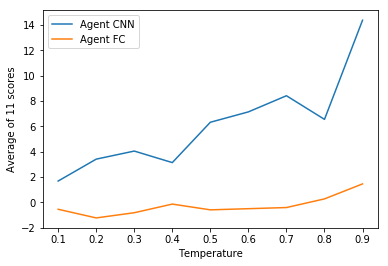

In [17]:
#env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')


temperatures = np.arange(0.1,1,0.1)
final_scores = {'agent_cnn':np.zeros(len(temperatures)), 'agent_fc':np.zeros(len(temperatures))}

for index,temperature in enumerate(temperatures):
    env = Environment(grid_size=size, max_time=T,temperature=temperature)
    
    print('Test of the CNN with temperature=' + str(temperature))
    final_scores['agent_cnn'][index] = test(agent_cnn,env,epochs_test,prefix='cnn_test')
    print('Test of the FC with temperature=' + str(temperature))
    final_scores['agent_fc'][index] = test(agent_fc,env,epochs_test,prefix='fc_test')

plt.plot(temperatures, final_scores['agent_cnn'], label='Agent CNN')
plt.plot(temperatures, final_scores['agent_fc'], label='Agent FC')
plt.xlabel('Temperature')
plt.ylabel('Average of 11 scores')
plt.legend()
plt.show()

In [18]:
HTML(display_videos('cnn_test10.avi'))

In [19]:
HTML(display_videos('fc_test10.avi'))

__Question 9)__

__CNN Agent > FC Agent:__

We observe that the CNN Agent is performing better than the FC Agent. 
The main reason might be because of the CNN layers that is well suited to this problem. 
In addition, the CNN Network have more parameters than the FC Network resulting in a better model.

__Observed Issues:__  
__1) Stuck in a small area__  
We can see on the videos that the agents stay stuck in a small area, which means that they are not exploring the entire board that could lead to better scores. This is due to their 2-wide cell's sight that limit their vision to a small area of the board.  
Hence Once an area has been explored, there is nothing left around leading to a policy equivalent to brownian movement which is known to stay at the same place in average.  
This issue is very common with low temperatures because a barrier of malus can lead to a stuck area in a short time.  
__2) Moving alternatively between 2 cells__  
We can also observe on the videos, that some agents keep moving alternatively between 2 neightbor cells. Maybe the agents think that the best move, when he is up, is to go down to get a bonus, then, when he is down, he thinks that the best move is to get up to get another bonus.   
This issue is very common with my FC Agents, this is why they get such low scores with high temperatures

__Remark:__  
We can notice that there are two different linear score behavior for the CNN Agent. One for temperatures lower than 0.6 and one for temperatures higher than 0.6. which could be explain by the vanishing of the first issue

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [20]:
def train_explore(agent, env, epoch, decay=0.5, epsilon=0.5, prefix=''):
    # Number of won games
    score = 0
    loss = 0
    
    # Set agent's epsilon to an initial epsilon
    agent.set_epsilon(epsilon)
    
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
    
        win = 0
        lose = 0
        
        # Decay epsilon at each epoch to a minimum of 0.1
        if e!=0:
            if agent.epsilon >= 0.1:
                agent.set_epsilon(agent.epsilon * decay)
            else:
                agent.set_epsilon(0.1)

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            
            #In train explore:
            state, reward, game_over = env.act(action, train=True)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
class EnvironmentExploring(Environment):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        super(EnvironmentExploring, self).__init__(grid_size=grid_size, max_time=max_time, temperature=temperature)
        
        self.malus_position = np.zeros((grid_size,grid_size))
    
    def act(self, action, train=False):
        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1 #Correct typo here

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        
        # You will have to change n_state to 3 because you will use one more layer!
        reward = 0
        if train:
            reward = -self.malus_position[self.x, self.y]
        reward += self.board[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.1

        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        
        # 3 "feature" states instead of 2
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over
    
    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:,-2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0
        
        # Added malus_position
        self.malus_position = np.zeros((self.grid_size, self.grid_size))
        self.malus_position[self.x, self.y] = 0.1
        
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

In [21]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore10.avi'))

Epoch 000/050 | Loss 0.0014 | Win/lose count 4.0/20.600000000000016 (-16.600000000000016)
Epoch 001/050 | Loss 0.0014 | Win/lose count 3.5/23.80000000000002 (-20.30000000000002)
Epoch 002/050 | Loss 0.0031 | Win/lose count 13.5/23.700000000000028 (-10.200000000000028)
Epoch 003/050 | Loss 0.0042 | Win/lose count 9.0/16.199999999999964 (-7.199999999999964)
Epoch 004/050 | Loss 0.0039 | Win/lose count 7.0/17.899999999999984 (-10.899999999999984)
Epoch 005/050 | Loss 0.0070 | Win/lose count 5.0/18.19999999999999 (-13.199999999999989)
Epoch 006/050 | Loss 0.0091 | Win/lose count 6.5/18.499999999999982 (-11.999999999999982)
Epoch 007/050 | Loss 0.0041 | Win/lose count 11.0/16.29999999999996 (-5.299999999999962)
Epoch 008/050 | Loss 0.0053 | Win/lose count 7.0/19.400000000000016 (-12.400000000000016)
Epoch 009/050 | Loss 0.0015 | Win/lose count 5.0/20.900000000000027 (-15.900000000000027)
Epoch 010/050 | Loss 0.0075 | Win/lose count 9.0/17.799999999999983 (-8.799999999999983)
Epoch 011/050 |

In [22]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.avi'))

Final score: 16.09090909090909


***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***